In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D, Dense, GlobalAveragePooling2D
from keras.models import load_model

In [7]:
# Define function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image
    img = load_img(image_path, target_size=(64, 64))
    # Convert image to array
    img_arr = img_to_array(img)
    # Normalize pixel values
    img_arr = img_arr / 255.0
    # Return preprocessed image
    return img_arr

def inception_module(inputs, num_filters):
    # 1x1 convolution branch
    conv1 = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    
    # 3x3 convolution branch
    conv3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    conv3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu')(conv3)
    
    # # 5x5 convolution branch
    # conv5 = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    # conv5 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, 5), padding='same', activation='relu')(conv5)
    
    # Max pooling branch
    pool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    pool = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(pool)
    
    # Concatenate outputs from all branches
    outputs = tf.keras.layers.concatenate([conv1, conv3, pool], axis=-1)
    
    return outputs

In [3]:
# Define paths to image directory and label csv file
image_dir = 'Cell_Data/Cell_Images/cells'
label_file = 'Cell_Data/label.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [4]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [8]:
# Define the model architecture
inputs = tf.keras.Input(shape=(64, 64, 3))
x = inception_module(inputs, num_filters=64)
x = inception_module(x, num_filters=128)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=7, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 64)   256         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 3)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 64)   256         ['input_2[0][0]']                
                                                                                            

In [9]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_inception_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/5
1269/1269 [==============================] - 2471s 2s/step - loss: 1.5043 - accuracy: 0.3665 - val_loss: 1.3724 - val_accuracy: 0.4263
Epoch 2/5
1269/1269 [==============================] - 2391s 2s/step - loss: 1.3089 - accuracy: 0.4727 - val_loss: 1.2832 - val_accuracy: 0.4877
Epoch 3/5
1269/1269 [==============================] - 2385s 2s/step - loss: 1.2392 - accuracy: 0.5069 - val_loss: 1.2322 - val_accuracy: 0.5193
Epoch 4/5
1269/1269 [==============================] - 3173s 3s/step - loss: 1.1544 - accuracy: 0.5524 - val_loss: 1.1116 - val_accuracy: 0.5871
Epoch 5/5
1269/1269 [==============================] - 2780s 2s/step - loss: 1.0866 - accuracy: 0.5829 - val_loss: 1.0597 - val_accuracy: 0.6196


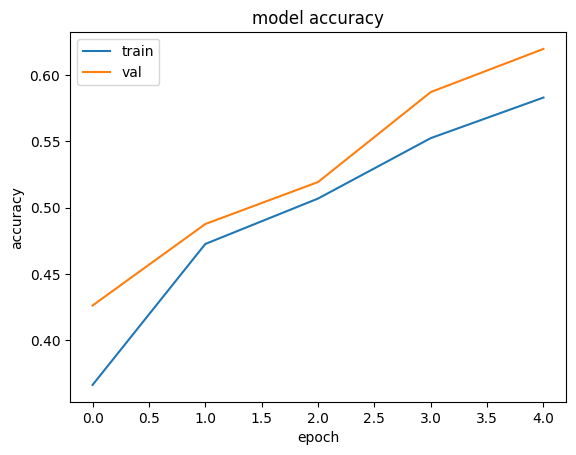

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

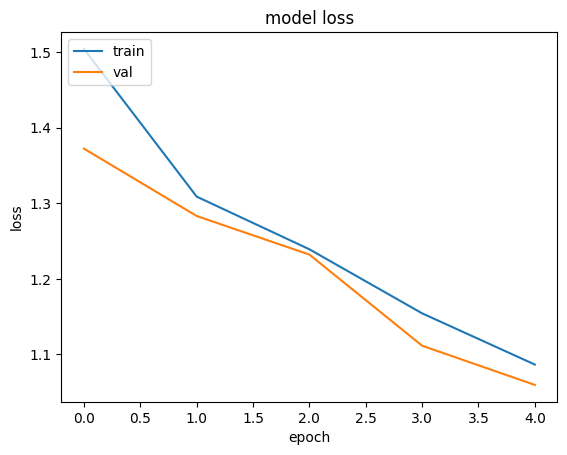

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

397/397 [==============================] - 154s 387ms/step - loss: 1.0639 - accuracy: 0.6170
Test loss: 1.0639127492904663
Test accuracy: 0.6169911026954651


In [13]:
best_model = load_model('best_inception_model.h5')

# Evaluate the model on the testing set
test_loss_b, test_accuracy_b = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss_b)
print('Test accuracy:', test_accuracy_b)

397/397 [==============================] - 152s 382ms/step - loss: 1.0639 - accuracy: 0.6170
Test loss: 1.0639127492904663
Test accuracy: 0.6169911026954651


In [14]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)

397/397 [==============================] - 157s 394ms/step


In [15]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[1952  440  356   42   70    0]
 [ 638 1606  314  300   16    0]
 [ 105  665 1779  126   11    0]
 [  19  231  109 2385    1    0]
 [ 338  249  268   45  107    0]
 [  33   80  144  243   17    0]]


In [16]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  1952
True Negatives (TN):  8696
False Positives (FP):  1133
False Negatives (FN):  908
Class 2
True Positives (TP):  1606
True Negatives (TN):  8150
False Positives (FP):  1665
False Negatives (FN):  1268
Class 3
True Positives (TP):  1779
True Negatives (TN):  8812
False Positives (FP):  1191
False Negatives (FN):  907
Class 4
True Positives (TP):  2385
True Negatives (TN):  9188
False Positives (FP):  756
False Negatives (FN):  360
Class 5
True Positives (TP):  107
True Negatives (TN):  11567
False Positives (FP):  115
False Negatives (FN):  900
Class 6
True Positives (TP):  0
True Negatives (TN):  12172
False Positives (FP):  0
False Negatives (FN):  517


In [17]:
from sklearn.metrics import classification_report

# Get the classification report
cr = classification_report(y_true, y_pred, digits=4)

print(cr)

              precision    recall  f1-score   support

           1     0.6327    0.6825    0.6567      2860
           2     0.4910    0.5588    0.5227      2874
           3     0.5990    0.6623    0.6291      2686
           4     0.7593    0.8689    0.8104      2745
           5     0.4820    0.1063    0.1741      1007
           6     0.0000    0.0000    0.0000       517

    accuracy                         0.6170     12689
   macro avg     0.4940    0.4798    0.4655     12689
weighted avg     0.5831    0.6170    0.5887     12689



c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  